In [14]:
# Import libraries

from cil.framework import  AcquisitionGeometry
from cil.optimisation.algorithms import Algorithm
from cil.optimisation.functions import Function, L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox, LeastSquares
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
# from cil.plugins.tigre import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D, show_geometry
from cil.utilities import noise
from cil.processors import Slicer

import matplotlib.pyplot as plt

import numpy as np

import importlib

In [17]:
# Define SAGAGradientFunction
import sys
cil_path = '/u/s/cd902/GitHub/CIL/'
fun_path = 'Wrappers/Python/cil/optimisation/functions'
sys.path.append(cil_path + fun_path)
import SubsetSumFunction

In [2]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

/home/cd902/miniconda3/envs/cilnew/lib/python3.9/site-packages/cil/utilities/display.py:358: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


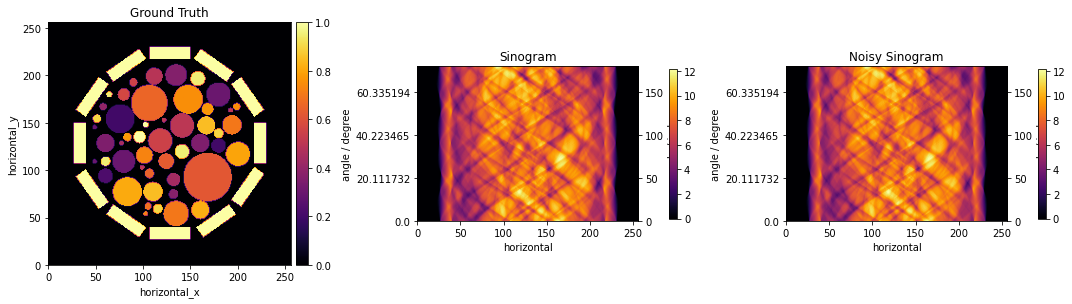

In [3]:
# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'gpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
# noisy_sino.fill(n1 + sino.array)
# noisy_sino.array[noisy_sino.array<0]=0
noisy_sino.fill(sino.array)

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title = ['Ground Truth','Sinogram','Noisy Sinogram'], num_cols=3, cmap = 'inferno')


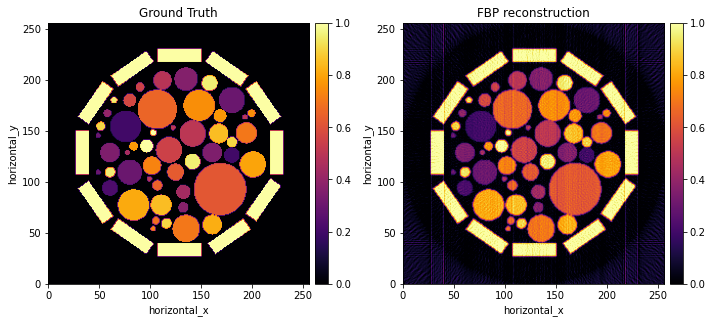

In [4]:
# Setup and run the FBP algorithm
fbp_recon = FBP(ig, ag,  device = 'gpu')(noisy_sino)

# Show reconstructions
show2D([phantom, fbp_recon], 
       title = ['Ground Truth','FBP reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))

# Gradient Descent (step) and ISTA as Class

In [5]:
                                            
class GradientDescent(Algorithm):
    """
        Gradient Descent w/o Armijo rule
        Convergence guarantee: step-size < 2/L where L is the lipschitz constant
        of the gradient of the objective function
    """

    def  __init__(self, initial=None, objective_function=None, step_size=1, **kwargs):

        super(GradientDescent, self).__init__(**kwargs)

        self.set_up(initial=initial, objective_function=objective_function, step_size=step_size)



    def set_up(self, initial, objective_function, step_size):

        self.x = initial.copy()
        self.objective_function = objective_function
        self.x_update = initial.copy()
        self.step_size = step_size
        self.update_objective()
        self.update_step_size = False        
        self.configured = True
        

    def update(self):
        '''Single iteration'''
        
        self.x_update = self.objective_function.gradient(self.x)
        
        self.x_update *= -self.step_size
        self.x += self.x_update

    def update_objective(self):
        self.loss.append(self.objective_function(self.x))

In [141]:
                                            
from SubsetSumFunction import SumFunction
class ISTA(Algorithm):
    """
        Iterative Shrinkage-Thresholding Algorithm
        Goal: minimize f + g with f smooth, g simple
        Convergence guarantee: 
        - f,g convex
        - step-size < 1/L where the gradient of f is L-Lipschitz
    """

    def  __init__(self, initial=None, f=None, g=None, step_size=1, **kwargs):

        super(ISTA, self).__init__(**kwargs)

        self.set_up(initial=initial, f=f, g=g, step_size=step_size)



    def set_up(self, initial, f, g, step_size):

        self.f = f
        self.g = g
        self.x = initial.copy()
        self.objective_function = SumFunction(f,g)
        self.x_update = initial.copy()
        self.step_size = step_size
        self.update_objective()
        self.update_step_size = False        
        self.configured = True
        

    def update(self):
        '''Single iteration'''
        
        self.x_update = self.f.gradient(self.x)
        self.x_update *= -self.step_size
        self.x += self.x_update
        self.x = self.g.proximal(self.x, self.step_size)

    def update_objective(self):
        self.loss.append(self.objective_function(self.x))

# Run simple Gradient Descent and ISTA

In [147]:
num_epochs = 20
f_gd = LeastSquares(A, noisy_sino)
initial = ig.allocate(0)
step_size = 2 / f_gd.L
gd = GradientDescent(initial=initial, objective_function=f_gd,
                     step_size=0.0009, update_objective_interval=1, 
                     max_iteration=1000)
gd.run(num_epochs, verbose=0)

In [146]:
initial = ig.allocate(0)
step_size = 1 / f_gd.L
g = IndicatorBox(lower=0)
ista = ISTA(initial=initial, f=f_gd, g=g,
                     step_size=step_size, update_objective_interval=1, 
                     max_iteration=1000)
ista.run(num_epochs, verbose=0)

# Setup subset framework from SAGA

In [32]:
# Define number of subsets
n_subsets = 10

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(noisy_sino)

    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig, ageom_subset)
    A_subsets.append(Ai)

    # Define F_i and put into list
    fi = LeastSquares(Ai, b = data_subset)
    f_subsets.append(fi)


# Define F and K
F = BlockFunction(*f_subsets)

# Run SAGA 

In [97]:
importlib.reload(SubsetSumFunction)
from SubsetSumFunction import SAGAGradientFunction

In [101]:
num_epochs = 20
F_saga = SAGAGradientFunction(F)
# admissible step-size is gamma = 1/ (3 max_i L_i)
step_size = 1 / (3*F_saga.Lmax)
initial = ig.allocate(0)
F_saga.memory_reset()
saga = GradientDescent(initial=initial, objective_function=F_saga,
                     step_size=step_size, update_objective_interval=n_subsets, 
                     max_iteration=10000)
saga.run(num_epochs * n_subsets, verbose=0)

In [79]:
# subsequent subsets: 1, 2, etc...
def subset_select_function(a,b):
    return (a+1)%b
F_saga = SAGAGradientFunction(F, subset_select_function=subset_select_function)
step_size = 1 / (3*F_saga.Lmax)
initial = ig.allocate(0)
F_saga.memory_reset()
saga_ss = GradientDescent(initial=initial, objective_function=F_saga,
                     step_size=step_size, update_objective_interval=n_subsets, 
                     max_iteration=10000)
saga_ss.run(num_epochs * n_subsets, verbose=0)

In [136]:
# precond
# D(x) = diag(x / A^T \1)
num_epochs = 20
cst = A.adjoint(A.range.allocate(1.))
precond = lambda i, x: x.divide(cst)
# csts = [Ai.adjoint(Ai.range.allocate(1.)) + epsilon for Ai in A_subsets]
# precond = lambda i, x: x.divide(csts[i]) 
F_saga = SAGAGradientFunction(F, precond=precond)
step_size = 0.1
initial = ig.allocate(1.)
F_saga.memory_reset()
saga_precond = GradientDescent(initial=initial, objective_function=F_saga,
                     step_size=step_size, update_objective_interval=n_subsets, 
                     max_iteration=10000)
saga_precond.run(num_epochs * n_subsets, verbose=0)

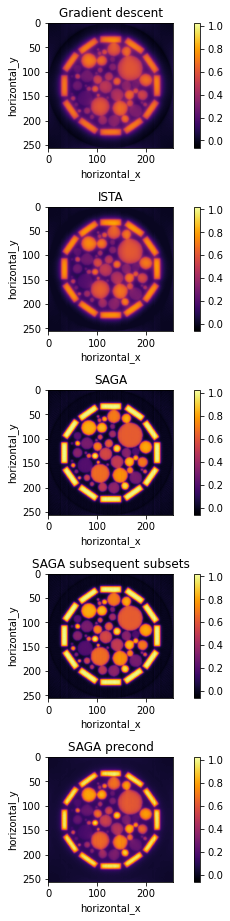

In [148]:
# Look at results
show2D([gd.solution, ista.solution, saga.solution, saga_ss.solution, saga_precond.solution], 
       origin="upper", 
       title=["Gradient descent","ISTA","SAGA", "SAGA subsequent subsets","SAGA precond"],
       fix_range=True, num_cols=1,
       cmap='inferno')

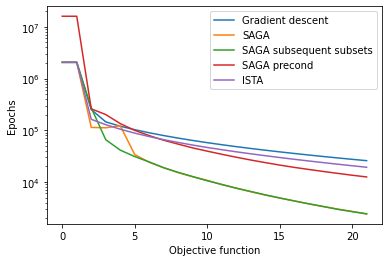

In [149]:
# compare results
plt.figure()
plt.semilogy(gd.objective, label="Gradient descent")
plt.semilogy(saga.objective, label="SAGA")
plt.semilogy(saga_ss.objective, label="SAGA subsequent subsets")
plt.semilogy(saga_precond.objective, label="SAGA precond")
plt.semilogy(ista.objective, label="ISTA")
plt.legend()
plt.ylabel('Epochs')
plt.xlabel('Objective function')
plt.show()

In [ ]:
# bla